<a href="https://colab.research.google.com/github/lsescares/aamemoria/blob/main/memoria_2_diciembre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import pandas as pd
import cv2
import math
from google.colab.patches import cv2_imshow
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology, io
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Identificacion celular

##Generacion comando txt cortar toda roi

In [45]:
%cd"/content/gdrive/MyDrive/memoria/"
!ls
#el comando ls deberia mostrar la imagen grande y el jupyterNotebook

/content/gdrive/MyDrive/memoria
 comandos_terminal.txt		   ejemplo_x2.5_z0.tif
 ejemplo.ndpi			   ejemplo_x5_z0.tif
 ejemplo_rois_dibujadas.tif	   ejemplo.xml
 ejemplo_rois_dibujadas_x2.5.tif  'estado 28 5 2021.gdoc'
 ejemplo_rois_dibujadas_x5.tif	   jueves22
 ejemplo_x0.625_z0.tif		   pre-resumen.gdoc
 ejemplo_x1.25_z0.tif		  'topicos de presentación avance 4 junio.gdoc'


In [46]:
def read_xml(ndpa_path):
    tree = ET.parse(ndpa_path)
    root = tree.getroot()
    anotaciones=root.findall(".//ndpviewstate")
    anotaciones_ndpiycolores=[]    
    anotaciones_ndpi=[]
    colores_roi = []
    for anotacion in anotaciones:
        color_roi = anotacion[10].attrib['color']
        l_aux=[]
        x_ndpi = int(anotacion[10][0].text)
        y_ndpi = int(anotacion[10][1].text)
        l_aux.append(x_ndpi)
        l_aux.append(y_ndpi)
        radio_ndpi = anotacion[10][2].text
        if radio_ndpi != 'pinred':#POR CORREGIR: casos donde el pin sea de otro color, ejemplo azul seria un pinblue
            radio_ndpi = int(radio_ndpi)
            l_aux.append(radio_ndpi)
            anotaciones_ndpi.append(l_aux)
            colores_roi.append(color_roi)
    anotaciones_ndpiycolores.append(anotaciones_ndpi)
    anotaciones_ndpiycolores.append(colores_roi)
    return anotaciones_ndpiycolores  

In [47]:
def transformacion_color2clase(colores_roi):
    mapeo_color2clase = {'#ff00ff' : '3+', 
                   '#0000ff' : '2+', 
                   '#ff0000' : '1+',
                   '#00ff00' : '0',
                   '#ffff00' : '0', 
                   '#000000' : 'no-tumor',
                   } 
    clases_roi = []
    for color in colores_roi:
        clases_roi.append(mapeo_color2clase[color])
    return clases_roi

def transformacion_clase2color(clases_roi):
    mapeo_clases2color = {'3+':'#ff00ff', 
                          '2+':'#0000ff',
                          '1+':'#ff0000',               
                          '0':'#00ff00',#CLASE 0 SIEMPRE LOS TIRARA A VERDE
                          '0':'#ffff00',
                          'no-tumor':'#000000'
                        } 
    colors_roi = []
    for clase in clases_roi:
        colors_roi.append(mapeo_clases2color[clase])
    return colors_roi

se ejecutan los comando txt en el computador y se ejecuta el macro para extrar los canales H y canal DAB. luego se suben a google drive y se procesa en las siguientes celdas.

In [48]:
def transformacion_ndpi2pixeles(anotaciones_ndpi):
    anotaciones_pixeles=[]
    for anotacion in anotaciones_ndpi:
        list_aux=[]
        x_ndpi = anotacion[0]
        y_ndpi = anotacion[1]
        x_pixeles = int((x_ndpi + 10010504)/227)
        y_pixeles = int((y_ndpi + 11736845)/227)
        radius = anotacion[2]
        radio_pixeles =int(radius/227)#forzamos que sea int porque son pixeles
        list_aux.append(x_pixeles)
        list_aux.append(y_pixeles)
        list_aux.append(radio_pixeles)
        anotaciones_pixeles.append(list_aux)
    return anotaciones_pixeles

def esquinas_cuadrado_roi(anotaciones_pixeles):
    contenedor_esquinayladocuadrado=[]
    for anotacion in anotaciones_pixeles:
        esquinayladocuadrado=[]
        x_roi = anotacion[0]
        y_roi = anotacion[1]
        radio = anotacion[2]
        lado_cuadrado = int(radio * math.sqrt(2)) 
        esq_sup_izq =[int(x_roi - radio/math.sqrt(2)),int(y_roi + radio/math.sqrt(2))]
        esquinayladocuadrado.append(esq_sup_izq)
        esquinayladocuadrado.append(lado_cuadrado)
        contenedor_esquinayladocuadrado.append(esquinayladocuadrado)
    return contenedor_esquinayladocuadrado

def comandos_terminal_ndpisplit_cuadrado_roi(contenedor_esquinayladocuadrado,clases_roi):
    comandos=[]
    ID_anotacion = 0
    for eyl in contenedor_esquinayladocuadrado: 
        x_sup_izq = str(eyl[0][0])
        y_sup_izq = str(eyl[0][1])
        ancho_parche = str(eyl[1])
        largo_parche = str(eyl[1])
        clase_roi = clases_roi[ID_anotacion]#ya es str
        ID_parche = 'a'+str(ID_anotacion) + '_clase_'+clase_roi                
        comandos.append('ndpisplit -Ex40,z0,'+ x_sup_izq +','+ y_sup_izq +','+ ancho_parche +','+ largo_parche +','+ ID_parche +' -K ejemplo.ndpi')
        #print('ndpisplit -Ex40,z0,0,0,'+str(int(esquina[0]))+','+str(int(esquina[1]))+',mylabel -K ejemplo.ndpi')
        ID_anotacion +=1    
    return comandos

def save_comandos_txt(comandos_ndpi):
    with open('comandos_terminal.txt', "w") as f:
        for comando in comandos_ndpi:
            f.write(str(comando) +"\n")

            

In [49]:
import os
#encontrar los paths de las imagenes H y DAB
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"

canalH_paths=[]
canalDAB_paths=[]
[canalH_paths.append(img_path) for img_path in os.listdir(base_path_H)]
[canalDAB_paths.append(img_path) for img_path in os.listdir(base_path_DAB)]

def sort_especial(paths_list):
    a=[]
    for l in paths_list:
        ID_anotacion = int(l.split('_')[3][1:])
        b=[]
        b.append(ID_anotacion)
        b.append(l)
        a.append(b)
    path_sorted=sorted(a, key=lambda x:x[0])
    path_final=[]
    [path_final.append(path[1]) for path in path_sorted]
    return path_final
    
canalH_paths = sort_especial(canalH_paths)#despues aplicar lo de hacerlo en forma de funcion que modifique el orden de la lista
canalDAB_paths = sort_especial(canalDAB_paths)
print(canalH_paths)
print(canalDAB_paths)


['ejemplo_x40_z0_a0_clase_3+.png-H.tif', 'ejemplo_x40_z0_a1_clase_2+.png-H.tif', 'ejemplo_x40_z0_a2_clase_0.png-H.tif', 'ejemplo_x40_z0_a3_clase_3+.png-H.tif', 'ejemplo_x40_z0_a4_clase_0.png-H.tif', 'ejemplo_x40_z0_a5_clase_0.png-H.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a9_clase_0.png-H.tif', 'ejemplo_x40_z0_a10_clase_2+.png-H.tif', 'ejemplo_x40_z0_a11_clase_2+.png-H.tif', 'ejemplo_x40_z0_a12_clase_2+.png-H.tif', 'ejemplo_x40_z0_a13_clase_1+.png-H.tif', 'ejemplo_x40_z0_a14_clase_2+.png-H.tif']
['ejemplo_x40_z0_a0_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a1_clase_2+.png-DAB.tif', 'ejemplo_x40_z0_a2_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a3_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a4_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a5_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.

## Experimento: Umbral de otsu

In [50]:
#from curso de mi profe guia, es la idea equivalente a otsu
from skimage import data, filters, measure, morphology,io

image = io.imread('/content/gdrive/MyDrive/memoria/jueves22/canalH/ejemplo_x40_z0_a0_clase_3+.png-H.tif')

threshold = filters.threshold_otsu(image)#otsu tiene que entrar un grey scale
print('threshold=',threshold)

binary=image<threshold#esto es lo de la indexacion

#imshow(binary, cmap='gray')
all_labels = measure.label(binary, background=0)

properties = measure.regionprops(all_labels)#<--- esto equivale a coneccted components, viene de skimage


threshold= 195


### Filtro las celulas muy pequeñas

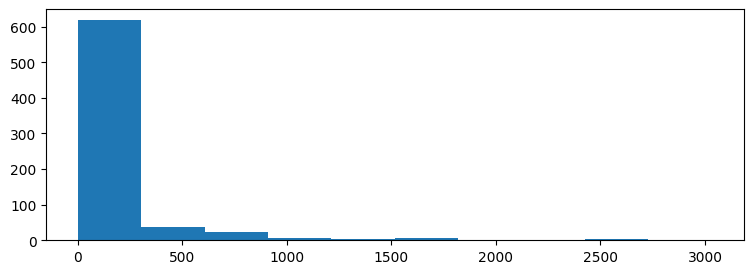

In [51]:
#properties es una lista de objetos:'RegionProperties', cada uno es una celula, tiene los atributos de la celula
properties_areas=[]
[properties_areas.append(propertie.area) for propertie in properties]
#'''
plt.figure(figsize=(9, 3))
plt.hist(properties_areas)
plt.show() #dibujamos el histograma
#'''
#print(properties_areas)

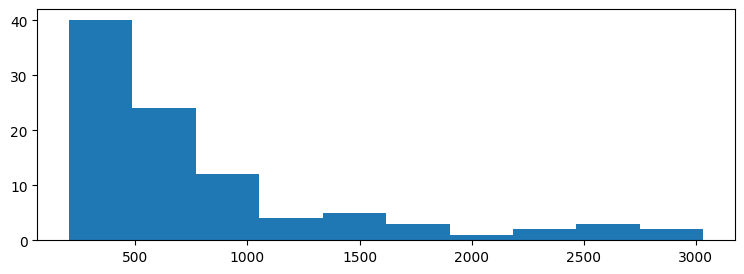

In [52]:
umbral_area = 200
properties_areas=[]
[properties_areas.append(propertie.area) for propertie in properties if propertie.area>umbral_area]
#'''
plt.figure(figsize=(9, 3))#<--- forma mas clara de hacer graficos
plt.hist(properties_areas)
plt.show() #dibujamos el histograma
#'''
#print(properties_areas)

conclusion: 200 es un buen umbral para el area de las propeties

In [53]:
#encontrar los paths de las imagenes H y DAB
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"

canalH_paths=[]
canalDAB_paths=[]
[canalH_paths.append(img_path) for img_path in os.listdir(base_path_H)]
[canalDAB_paths.append(img_path) for img_path in os.listdir(base_path_DAB)]

canalH_paths = sort_especial(canalH_paths)#despues aplicar lo de hacerlo en forma de funcion que modifique el orden de la lista
canalDAB_paths = sort_especial(canalDAB_paths)
print(canalH_paths)
print(canalDAB_paths)

['ejemplo_x40_z0_a0_clase_3+.png-H.tif', 'ejemplo_x40_z0_a1_clase_2+.png-H.tif', 'ejemplo_x40_z0_a2_clase_0.png-H.tif', 'ejemplo_x40_z0_a3_clase_3+.png-H.tif', 'ejemplo_x40_z0_a4_clase_0.png-H.tif', 'ejemplo_x40_z0_a5_clase_0.png-H.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a9_clase_0.png-H.tif', 'ejemplo_x40_z0_a10_clase_2+.png-H.tif', 'ejemplo_x40_z0_a11_clase_2+.png-H.tif', 'ejemplo_x40_z0_a12_clase_2+.png-H.tif', 'ejemplo_x40_z0_a13_clase_1+.png-H.tif', 'ejemplo_x40_z0_a14_clase_2+.png-H.tif']
['ejemplo_x40_z0_a0_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a1_clase_2+.png-DAB.tif', 'ejemplo_x40_z0_a2_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a3_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a4_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a5_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.

In [54]:
def juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths):
    paths_HDAB=[]
    for i in range(len(canalH_paths)):
        aux=[]
        aux.append(canalH_paths[i])
        aux.append(canalDAB_paths[i])
        paths_HDAB.append(aux)
    return paths_HDAB

def or_masks(boolean_mask1, boolean_mask2):
    if boolean_mask1.shape != boolean_mask2.shape:
        raise Exception('boolean_mask1 y boolean_mask2 deben tener la misma dimension')
    boolean_mask_result = np.full_like(boolean_mask1, fill_value = False, dtype=bool)#crea un numpy array lleno con False de dimensiones iguales a boolean_mask1
    for i in range(boolean_mask1.shape[1]):
        for j in range(boolean_mask1.shape[0]):
            if boolean_mask1[i,j]==True or boolean_mask2[i,j]==True:
                boolean_mask_result[i,j]=True
    return boolean_mask_result 

def reconstruir_mask(lado_parche,list_propertie):#recontruye la maskara con todas las celulas a partir de la lista de objetos properties
    mask = np.full((lado_parche, lado_parche),False, dtype= bool)
    for propertie in list_propertie:
        for coord in propertie.coords:
            i = coord[0]
            j = coord[1] 
            mask[i,j] = True
    return mask

###Determinacion umbral area minima y maxima

In [55]:
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"
paths_HDAB = juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths)
HDAB=[]
H_features=[]
lista_properties=[]

path_H = paths_HDAB[0][0]
path_DAB = paths_HDAB[0][1]

image_H = io.imread(base_path_H+path_H)
threshold_H = filters.threshold_otsu(image_H)#tiene que entrar un gray scale a otsu
img_H_binary = image_H<threshold_H

image_DAB = io.imread(base_path_DAB+path_DAB)
threshold_DAB = filters.threshold_otsu(image_DAB)#tiene que entrar un gray scale a otsu
img_DAB_binary = image_DAB<threshold_DAB


img_binary_merged = or_masks(img_H_binary, img_DAB_binary)

all_labels = measure.label(img_binary_merged, background=0)
properties = measure.regionprops(all_labels)
#filtro por area minima de 250
umbral_area_celula_minima=250
lista_properties_filtrada=[propertie for propertie in properties if propertie.area > 250 ]

#propertie_cords2mask(lado_parche,propertie_cords)
#lado_parche = image_H.shape[0]
#mask_merged_filtered = reconstruir_mask(lado_parche, lista_properties_filtrada)

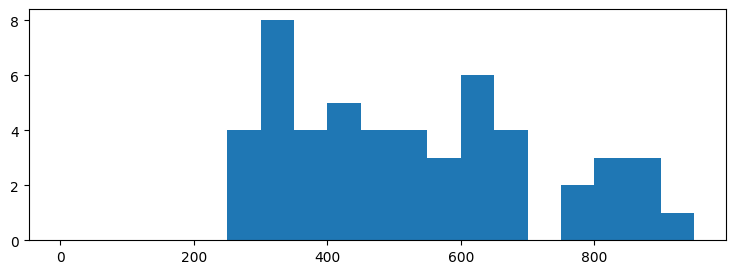

count       84.000000
mean      1963.428571
std       4351.918891
min        255.000000
25%        462.250000
50%        734.000000
75%       1507.750000
max      31691.000000
dtype: float64

In [56]:
umbral_area = 250
properties_areas=[propertie.area for propertie in properties if propertie.area>umbral_area]
#'''
plt.figure(figsize=(9, 3))#<--- forma mas clara de hacer graficos
plt.hist(properties_areas, bins=np.arange(0,1000,50))
plt.show() #dibujamos el histograma
#'''
#print(properties_areas)
import pandas as pd
pd.Series(properties_areas).describe()

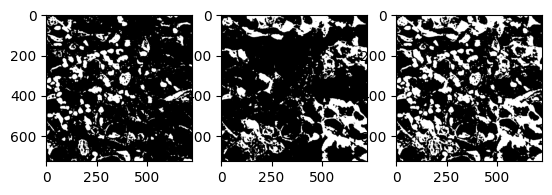

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img_H_binary,cmap='gray')
ax2.imshow(img_DAB_binary,cmap='gray')
ax3.imshow(img_binary_merged,cmap='gray')

#Feature extracion - resultado: HDAB

In [58]:
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology, io
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"
paths_HDAB = juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths)
HDAB=[]
H_features=[]
DAB_features=[]

lista_properties=[]

for path_HDAB in tqdm(paths_HDAB):#las imagenes de la carpeta canal_H ya estan en gray scale
    path_H = path_HDAB[0]
    path_DAB = path_HDAB[1]
    
    image_H = io.imread(base_path_H+path_H)
    threshold_H = filters.threshold_otsu(image_H)#tiene que entrar un gray scale a otsu
    img_H_binary = image_H<threshold_H
    image_DAB = io.imread(base_path_DAB+path_DAB)
    threshold_DAB = filters.threshold_otsu(image_DAB)#tiene que entrar un gray scale a otsu
    img_DAB_binary = image_DAB<threshold_DAB
    img_binary_merged = or_masks(img_H_binary, img_DAB_binary)
    
    all_labels = measure.label(img_binary_merged, background=0)
    properties_anotacion = measure.regionprops(all_labels)
    #filtro por area minima y maxima (de 250 y 1000)
    umbral_area_celula_minima = 250
    umbral_area_celula_maxima = 1250 
    lista_properties_filtrada = [propertie for propertie in properties_anotacion if propertie.area > umbral_area_celula_minima and propertie.area < umbral_area_celula_maxima]
    ###########################################################
    lista_properties.append(lista_properties_filtrada)#es para un proceso externo de guardar las propeties sacadas para cadda anotacion considerando los dos canales
    ###########################################################
    H_anotation=[]
    DAB_anotation=[]

    for celula_propertie in properties_anotacion:
            radio_condicion = 5#para que tenga sentido tiene que se menor que sqrt(area_minima/p1), para 250, menor a 9
            #skimage guardas imagenes en y,x es decir el shape[0] da la medicion de y, y el shape[1] da la de x
            y_centroid = int(celula_propertie.centroid[0])
            x_centroid = int(celula_propertie.centroid[1])
            for coord in celula_propertie.coords:
                y_coord = coord[0]
                x_coord = coord[1]
                a = (y_centroid-y_coord)**2+(x_centroid-x_coord)**2
                if a < radio_condicion**2:#si la coordenada esta dentro del radio
                    H_anotation.append( image_H[coord[1],coord[0]] )#el canal H y el DAB esta siendo leido en ByN 
                    DAB_anotation.append( image_DAB[coord[1],coord[0]] )
    H_features.append(H_anotation)
    DAB_features.append(DAB_anotation)        
        
HDAB.append(H_features)  
HDAB.append(DAB_features)    

#############################################################
#agregando tercera componenete con colores

clases_roi=[]
[clases_roi.append(img_path.split('_')[5].split('.')[0]) for img_path in canalH_paths]
colores_roi = transformacion_clase2color(clases_roi)
HDAB.append(colores_roi)   
HDAB.append(clases_roi) 
#'''


100%|██████████| 15/15 [01:34<00:00,  6.33s/it]


## Scatter plot

Graficos tienen una linea en 190 porque se binariza con la mascara del canal H y el umbral es en torno als 200

In [ ]:
plt.rcParams['axes.labelsize']=50
plt.rcParams['xtick.labelsize']=40    #tamaño de los numeros del eje X
plt.rcParams['ytick.labelsize']=40    #tamaño de los numeros del eje Y
plt.rcParams['xtick.color']='magenta'        #color numenos eje X
plt.rcParams['ytick.color']='magenta'      #color numenos eje Y
plt.rcParams['axes.labelcolor']='magenta'  #color de los nombres de los ejes
plt.rcParams['axes.grid']=True            #por defecto, printear la grilla
#vizualizacion

import pandas as pd
import matplotlib.pyplot as plt       

plt.clf()
fig, ax = plt.subplots(figsize=(40,40))
ax.set(xlim=(0, 255), ylim=(0, 255))

try:#cada ax.scatter plotea los pixeles de una anotacion)

    plt.text(10, 150, 'clase 3+ en magenta',fontsize=40, color='m')
    ax.scatter(HDAB[0][0] , HDAB[1][0], color= HDAB[2][0] )#clase: 3+ MAGENTA
    ax.scatter(HDAB[0][3] , HDAB[1][3], color= HDAB[2][3] )#clase: 3+ MAGENTA
    
    plt.text(10, 140, 'clase 2+ en azul',fontsize=40, color='b')
    ax.scatter(HDAB[0][1] , HDAB[1][1], color= HDAB[2][1] )#clase: 2+ AZUL
    ax.scatter(HDAB[0][10] , HDAB[1][10], color= HDAB[2][10] )#clase: 2+ AZUL
    ax.scatter(HDAB[0][11] , HDAB[1][11], color= HDAB[2][11] )#clase: 2+ AZUL
    ax.scatter(HDAB[0][12] , HDAB[1][12], color= HDAB[2][12] )#clase: 2+ AZUL
    ax.scatter(HDAB[0][14] , HDAB[1][14], color= HDAB[2][14] )#clase: 2+ AZUL

    plt.text(10, 130, 'clase 1+ en rojo',fontsize=40, color='r') 
    ax.scatter(HDAB[0][13] , HDAB[1][13], color= HDAB[2][13] )#clase: 1+ ROJO
    
    plt.text(10, 120, 'clase 0+ en amarillo',fontsize=40, color='y') 
    ax.scatter(HDAB[0][2] , HDAB[1][2], color= HDAB[2][2] )#clase: 0 VERDE (O AMARILLO)
    ax.scatter(HDAB[0][4] , HDAB[1][4], color= HDAB[2][4] )#clase: 0 VERDE (O AMARILLO)
    ax.scatter(HDAB[0][5] , HDAB[1][5], color= HDAB[2][5] )#clase: 0 VERDE (O AMARILLO)
    ax.scatter(HDAB[0][9] , HDAB[1][9], color= HDAB[2][9] )#clase: 0 VERDE (O AMARILLO)
    
    plt.text(10, 110, 'clase no_tumor en negro',fontsize=40, color='k') 
    ax.scatter(HDAB[0][6] , HDAB[1][6], color= HDAB[2][6] )#clase: no_tumor NEGRO 
    ax.scatter(HDAB[0][7] , HDAB[1][7], color= HDAB[2][7] )#clase: no_tumor NEGRO
    ax.scatter(HDAB[0][8] , HDAB[1][8], color= HDAB[2][8] )#clase: no_tumor NEGRO
    

except:
    pass
#legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="clases")
#ax.add_artist(legend1)

ax.set_xlabel('Hematoxilina H (0-255)')
ax.set_ylabel('DAB Diaminobencidina (0-255)')
plt.show()
plt.style.use('default')

<Figure size 640x480 with 0 Axes>

#Clasificacion

##Construyendo el modelo Kmeans

### Calculando los centroides

In [ ]:
def get_indexacion(lista_clases, clase):#la clase debe entrar como string
    indices_aparicion = []
    n_apariciones = lista_clases.count(clase)
    c = 0
    partida_busqueda=0
    while c < n_apariciones:
        indice = lista_clases.index(clase,partida_busqueda)
        partida_busqueda=indice+1
        indices_aparicion.append(indice)
        c+=1
    return indices_aparicion


In [ ]:
#calculando los centroides de las clases
import numpy as np
centroides=[]#largo 5 porque son 5 clases

indexacion_clase_anotacion=[]
[indexacion_clase_anotacion.append(img_path.split('_')[5].split('.')[0]) for img_path in canalH_paths]

indices_clase_no_tumor = get_indexacion(indexacion_clase_anotacion,'no-tumor')
indices_clase_0 = get_indexacion(indexacion_clase_anotacion,'0')
indices_clase_1 = get_indexacion(indexacion_clase_anotacion,'1+')
indices_clase_2 = get_indexacion(indexacion_clase_anotacion,'2+')
indices_clase_3 = get_indexacion(indexacion_clase_anotacion,'3+')

#colors = HDAB.pop(2)#elminar la ultima lista que tiene los colores de las clases

H_feat=HDAB[0]
DAB_feat=HDAB[1]
mean_H_feat=[]
mean_DAB_feat=[]
[mean_H_feat.append(sum(l)/len(l)) for l in H_feat]
[mean_DAB_feat.append(sum(l)/len(l)) for l in DAB_feat]


#'''
H_means_clase_no_tumor=[mean_H_feat[i] for i in indices_clase_no_tumor]#las listas son mutables
#www.freecodecamp.org/espanol/news/explicacion-de-las-listas-de-python-comprension-de-len-pop-index-y-list-comprehension
H_means_clase_0=[mean_H_feat[i] for i in indices_clase_0]
H_means_clase_1=[mean_H_feat[i] for i in indices_clase_1]
H_means_clase_2=[mean_H_feat[i] for i in indices_clase_2]
H_means_clase_3=[mean_H_feat[i] for i in indices_clase_3]

DAB_means_clase_no_tumor=[mean_DAB_feat[i] for i in indices_clase_no_tumor]#las listas son mutables
DAB_means_clase_0=[mean_DAB_feat[i] for i in indices_clase_0]
DAB_means_clase_1=[mean_DAB_feat[i] for i in indices_clase_1]
DAB_means_clase_2=[mean_DAB_feat[i] for i in indices_clase_2]
DAB_means_clase_3=[mean_DAB_feat[i] for i in indices_clase_3]

H_mean_clase_no_tumor = int(sum(H_means_clase_no_tumor)/len(H_means_clase_no_tumor))
H_mean_clase_0 = int(sum(H_means_clase_0)/len(H_means_clase_0))
H_mean_clase_1 = int(sum(H_means_clase_1)/len(H_means_clase_1))
H_mean_clase_2 = int(sum(H_means_clase_2)/len(H_means_clase_2))
H_mean_clase_3 = int(sum(H_means_clase_3)/len(H_means_clase_3))

DAB_mean_clase_no_tumor = int(sum(DAB_means_clase_no_tumor)/len(DAB_means_clase_no_tumor))
DAB_mean_clase_0 = int(sum(DAB_means_clase_0)/len(DAB_means_clase_0))
DAB_mean_clase_1 = int(sum(DAB_means_clase_1)/len(DAB_means_clase_1))
DAB_mean_clase_2 = int(sum(DAB_means_clase_2)/len(DAB_means_clase_2))
DAB_mean_clase_3 = int(sum(DAB_means_clase_3)/len(DAB_means_clase_3))

centroide_clase_no_tumor=[H_mean_clase_no_tumor,DAB_mean_clase_no_tumor]
centroide_clase_0=[H_mean_clase_0,DAB_mean_clase_0]
centroide_clase_1=[H_mean_clase_1,DAB_mean_clase_1]
centroide_clase_2=[H_mean_clase_2,DAB_mean_clase_2]
centroide_clase_3=[H_mean_clase_3,DAB_mean_clase_3]

centroides.append(centroide_clase_no_tumor)
centroides.append(centroide_clase_0)
centroides.append(centroide_clase_1)
centroides.append(centroide_clase_2)
centroides.append(centroide_clase_3)
print(centroides)


In [ ]:
plt.rcParams['axes.labelsize']=50
plt.rcParams['xtick.labelsize']=40    #tamaño de los numeros del eje X
plt.rcParams['ytick.labelsize']=40    #tamaño de los numeros del eje Y
plt.rcParams['xtick.color']='magenta'        #color numenos eje X
plt.rcParams['ytick.color']='magenta'      #color numenos eje Y
plt.rcParams['axes.labelcolor']='magenta'  #color de los nombres de los ejes
plt.rcParams['axes.grid']=True            #por defecto, printear la grilla
#vizualizacion

import pandas as pd
import matplotlib.pyplot as plt       

plt.clf()
fig, ax = plt.subplots(figsize=(40,40))
ax.set(xlim=(0, 255), ylim=(0, 255))

try:#cada ax.scatter plotea los pixeles de una anotacion
    plt.text(10, 150, 'clase 3+ en magenta',fontsize=40, color='m')
    #ax.scatter(HDAB[0][0] , HDAB[1][0], color= HDAB[2][0] )#clase: 3+ MAGENTA
    #ax.scatter(HDAB[0][3] , HDAB[1][3], color= HDAB[2][3] )#clase: 3+ MAGENTA
    plt.scatter(centroide_clase_3[0], centroide_clase_3[1], s=1000, marker='^', c='m')


    plt.text(10, 140, 'clase 2+ en azul',fontsize=40, color='b')
    #ax.scatter(HDAB[0][1] , HDAB[1][1], color= HDAB[2][1] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][10] , HDAB[1][10], color= HDAB[2][10] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][11] , HDAB[1][11], color= HDAB[2][11] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][12] , HDAB[1][12], color= HDAB[2][12] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][14] , HDAB[1][14], color= HDAB[2][14] )#clase: 2+ AZUL
    plt.scatter(centroide_clase_2[0], centroide_clase_2[1], s=1000, marker='^', c='b')

    plt.text(10, 130, 'clase 1+ en rojo',fontsize=40, color='r') 
    #ax.scatter(HDAB[0][13] , HDAB[1][13], color= HDAB[2][13] )#clase: 1+ ROJO
    plt.scatter(centroide_clase_1[0], centroide_clase_1[1], s=1000, marker='^', c='r')

    plt.text(10, 120, 'clase 0+ en amarillo',fontsize=40, color='y') 
    #ax.scatter(HDAB[0][2] , HDAB[1][2], color= HDAB[2][2] )#clase: 0 amarillo (o verde)
    #ax.scatter(HDAB[0][4] , HDAB[1][4], color= HDAB[2][4] )#clase: 0 amarillo (o verde)
    #ax.scatter(HDAB[0][5] , HDAB[1][5], color= HDAB[2][5] )#clase: 0 amarillo (o verde)
    #ax.scatter(HDAB[0][9] , HDAB[1][9], color= HDAB[2][9] )#clase: 0 amarillo (o verde)
    plt.scatter(centroide_clase_0[0], centroide_clase_0[1], s=1000, marker='^', c='y')

    plt.text(10, 110, 'clase no_tumor en negro',fontsize=40, color='k') 
    #ax.scatter(HDAB[0][6] , HDAB[1][6], color= HDAB[2][6] )#clase: no_tumor NEGRO 
    #ax.scatter(HDAB[0][7] , HDAB[1][7], color= HDAB[2][7] )#clase: no_tumor NEGRO
    #ax.scatter(HDAB[0][8] , HDAB[1][8], color= HDAB[2][8] )#clase: no_tumor NEGRO
    plt.scatter(centroide_clase_no_tumor[0], centroide_clase_no_tumor[1], s=1000, marker='^', c='k')
except:
    pass
#legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="clases")
#ax.add_artist(legend1)

ax.set_xlabel('Hematoxilina H (0-255)')
ax.set_ylabel('DAB Diaminobencidina (0-255)')
plt.show()

###Clasificando los pixeles de las roi

In [ ]:
from math import sqrt
def clasificar_muestra(centroides,muestra_HDAB):
    clase=['0','1+','2+','3+','no-tumor']
    distancias_muestraHDAB_centroides=[]
    for centroide in centroides:
        d = math.sqrt((centroide[0]-muestra_HDAB[0])**2+(centroide[1]-muestra_HDAB[1])**2)
        distancias_muestraHDAB_centroides.append(d)
    index_min = distancias_muestraHDAB_centroides.index(min(distancias_muestraHDAB_centroides))
    prediccion_clase = clase[index_min]
    #print('prediccion_clase para muestra = ', prediccion_clase)
    #print('con distancia:',min(distancias_muestraHDAB_centroides))
    #print('-----------------------------------------------------')
    return prediccion_clase

def clase2intnumber_encoding(clase):
    mapeo_clase2numero = {'0':int(0),
                          '1+':int(1), 
                          '2+':int(2),
                          '3+':int(3),               
                          'no-tumor':int(4)
                        } 
    intnumber = mapeo_clase2numero[clase]
    return intnumber    

def intnumber2rgbcolor_encoding(intnumber):#al final esta no se va a usar
    mapeo_intnumber2rgbcolor = {int(0): (255, 0, 255),#clase 0
                                int(1): (0, 0, 255),#clase 1
                                int(2): (255, 0, 0),#clase 2
                                int(3): (255, 255, 0),#clase 3         
                                int(4): (0, 0, 0)#clase no-tumor
                                } 
    rgbcolor = mapeo_intnumber2rgbcolor[intnumber]
    return rgbcolor    

def clase2rgbcolor_encoding(clase):
    mapeo_clase2rgbcolor = {'0': (255, 0, 255),#clase 0 verde
                            '1+': (0, 0, 255),#clase 1 rojo
                            '2+': (255, 0, 0),#clase 2 azul
                            '3+': (255, 255, 0),#clase 3 magenta        
                            'no-tumor': (0, 0, 0)#clase no-tumor
                            } 
    rgbcolor_tuple = mapeo_clase2rgbcolor[clase]
    return rgbcolor_tuple


In [ ]:
def juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths):
    paths_HDAB=[]
    for i in range(len(canalH_paths)):
        aux=[]
        aux.append(canalH_paths[i])
        aux.append(canalDAB_paths[i])
        paths_HDAB.append(aux)
    return paths_HDAB

paths_HDAB = juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths)

##Clasificando
entra HDAB y path y sale una lista con maskaras, una por cada anitacion, cada pixel de ellas tiene valores de 0 (clase no-tumor) a 5 (clase 3+)

###Clasificación por clase mayoritaria en celula

entra la lista con las properties que se sacaron de las mascaras H y DAB ya mergeadas.

In [ ]:
#prediccion como tal:
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology, io
import pandas as pd
lista_predicted_img_mask=[]
lista_predicted_img_mask_class=[]
aux_index_lista_properties = 0
for paths in tqdm(paths_HDAB):

    image_H = io.imread(base_path_H+paths[0])
    image_DAB = io.imread(base_path_DAB+paths[1])#paths[1] son los paths de las imgenes DAB
    
    #creamos una mascara de zeros con la misma dimension que la imagen
    #predicted_img_mask = np.zeros_like(image_H)
    mask_shape = (image_H.shape[0],image_H.shape[1],3)
    predicted_img_mask = np.full(shape = mask_shape, fill_value=0, dtype=np.int)
    predicted_img_mask_class= np.full(shape = (image_H.shape[0],image_H.shape[1]), fill_value=0, dtype=np.int)
  
    for celula_propertie in lista_properties[aux_index_lista_properties]:
            #creamos un objeto Series de pandas, como indice tiene los nombres de las clases y como info puros ceros que representan los votos
            votos_clases_en_celula = pd.Series([0, 0, 0, 0, 0], index = ['no-tumor', '0', '1+', '2+','3+'])
            for coord in celula_propertie.coords:
                muestra_HDAB = ( image_H[coord[1],coord[0]] , image_DAB[coord[1],coord[0]] )
                prediccion_clase = clasificar_muestra(centroides,muestra_HDAB)#prediccion_clase es un str puede ser 'no-tumor','0+','1+','2+' o '3+']
                #en caso de error revizar opencv leen en bgr y no en rgb
                votos_clases_en_celula[prediccion_clase] +=1#esto suma 1 voto a la clase correspondiente
            clase_mas_votos_celula = votos_clases_en_celula.idxmax()#idxmax es una funcion de pandas retorna el indice de entre los valores(informacion) que tenda mayor valor    
            
            for coord in celula_propertie.coords:#pintar toda la celula del mismo color de la clase mayoritaria
                #indices tiene que ir especificamente en esa posicion.
                predicted_img_mask[coord[0],coord[1],0] = clase2rgbcolor_encoding(clase_mas_votos_celula)[0]#estan bien definidos
                predicted_img_mask[coord[0],coord[1],1] = clase2rgbcolor_encoding(clase_mas_votos_celula)[1]
                predicted_img_mask[coord[0],coord[1],2] = clase2rgbcolor_encoding(clase_mas_votos_celula)[2]
                predicted_img_mask_class[coord[1],coord[0]] = clase2intnumber_encoding(clase_mas_votos_celula)
    aux_index_lista_properties +=1

    lista_predicted_img_mask.append(predicted_img_mask)
    lista_predicted_img_mask_class.append(predicted_img_mask_class)

In [ ]:
#EJEMPLO CLASIFICACION UNA ANOTACION
plt.style.use('default')
indice_mask= 1
lado_img = lista_predicted_img_mask[indice_mask].shape[0]

plt.imshow(lista_predicted_img_mask[indice_mask])
plt.title('anotacion '+str(indice_mask)+', clase patologo: '+ str(HDAB[3][indice_mask]))

pos_texto = lado_img+50
plt.text(pos_texto, 100, 'clase 3+ -> magenta',fontsize=12, color = 'm') 
plt.text(pos_texto, 200, 'clase 2+ -> azul',fontsize=12, color = 'b') 
plt.text(pos_texto, 300, 'clase 1+ -> rojo',fontsize=12, color = 'r') 
plt.text(pos_texto, 400, 'clase 0 -> amarillo',fontsize=12, color = 'y') 
plt.text(pos_texto, 500, 'clase no-tumor-> negro',fontsize=12, color = 'k')
#plt.colorbar()




In [ ]:
#A partir de las lista de listas de propertie genera las maskaras finales de las celulas que se detectaron
lista_lados_parches = []
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
canalH_paths=[img_path for img_path in os.listdir(base_path_H)]
canalH_paths = sort_especial(canalH_paths)
for path in canalH_paths: 
    image = io.imread(base_path_H+path)
    lista_lados_parches.append(image.shape[0])
################### ¿como entender la lista de listas de propertie? ########################
#las properties son las componentes conexas, una propertie es una celula
#para cada mascara vinaria skimage genera una lista de properties
#yo guardo una lista de esas listas de properties, en la variable llamada: lista_properties.
#ahora, en esta celda le di un nombre mas largo para que quede mas claro.
lista_de_lista_de_propertie = lista_properties
i = 0
maskaras_resultantes=[]
for lista_propertie in lista_de_lista_de_propertie:
    mask = reconstruir_mask(lista_lados_parches[i],lista_propertie)
    maskaras_resultantes.append(mask)
    i+=1


In [ ]:
plt.imshow(maskaras_resultantes[14],cmap='gray')

In [ ]:
def or_masks(boolean_mask1, boolean_mask2):
    if boolean_mask1.shape != boolean_mask2.shape:
        raise Exception('boolean_mask1 y boolean_mask2 deben tener la misma dimension')
    boolean_mask_result = np.full_like(boolean_mask1, fill_value = False, dtype=bool)#crea un numpy array lleno con False de dimensiones iguales a boolean_mask1
    for i in range(boolean_mask1.shape[1]):
        for j in range(boolean_mask1.shape[0]):
            if boolean_mask1[i,j]==True or boolean_mask2[i,j]==True:
                boolean_mask_result[i,j]=True
    return boolean_mask_result 

def reconstruir_mask(lado_parche,list_propertie):#recontruye la maskara con todas las celulas a partir de la lista de objetos properties
    mask = np.full((lado_parche, lado_parche),False, dtype= bool)
    for propertie in list_propertie:
        for coord in propertie.coords:
            i = coord[0]
            j = coord[1] 
            mask[i,j] = True
    return mask

In [ ]:
#EJEMPLO CLASIFICACION UNA ANOTACION Y ANOTACION ORIGINAL
plt.style.use('default')

indice_mask= 0
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('anotacion '+str(indice_mask)+', clase : '+ str(HDAB[3][indice_mask]))
ax1.imshow(lista_predicted_img_mask[indice_mask])

base_path_rgb = '/content/gdrive/MyDrive/memoria/jueves22/png_imgs/'
rgb_img_paths=sort_especial( [img_path for img_path in os.listdir(base_path_rgb)] )
rgb_image = io.imread(base_path_rgb + rgb_img_paths[indice_mask])
ax2.imshow(rgb_image)

lado_img = lista_predicted_img_mask[indice_mask].shape[0]
pos_texto = lado_img+50
plt.title('anotacion '+str(indice_mask)+', clase patologo: '+ str(HDAB[3][indice_mask]))

plt.text(pos_texto, 100, 'clase 3+ -> magenta',fontsize=12, c='m') 
plt.text(pos_texto, 200, 'clase 2+ -> azul',fontsize=12, c='b') 
plt.text(pos_texto, 300, 'clase 1+ -> rojo',fontsize=12, c='r') 
plt.text(pos_texto, 400, 'clase 0 -> amarillo/verde',fontsize=12, c='y') 
plt.text(pos_texto, 500, 'clase no-tumor-> negro',fontsize=12, c='k')

plt.savefig('/content/gdrive/MyDrive/memoria/jueves22/resultados_plots/a'+str(indice_mask)+'.png')



In [ ]:
#EJEMPLO una CLASIFICACION, una ANOTACION Y ANOTACION ORIGINAL
plt.style.use('default')

base_path_rgb = '/content/gdrive/MyDrive/memoria/jueves22/png_imgs/'
rgb_img_paths=sort_especial( [img_path for img_path in os.listdir(base_path_rgb)] )

indice_mask= 0
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
#fig.suptitle('anotacion '+str(indice_mask)+', clase : '+ str(HDAB[3][indice_mask]))
ax1.imshow(lista_predicted_img_mask[indice_mask])
rgb_image = io.imread(base_path_rgb+rgb_img_paths[indice_mask])
ax2.imshow(rgb_image)

ax3.imshow(maskaras_resultantes[indice_mask],cmap='gray')

lado_img = lista_predicted_img_mask[indice_mask].shape[0]
pos_texto = lado_img+50
plt.title('anotacion '+str(indice_mask)+', clase patologo: '+ str(HDAB[3][indice_mask]))

plt.text(pos_texto, 100, 'clase 3+ -> magenta',fontsize=12, c='m') 
plt.text(pos_texto, 200, 'clase 2+ -> azul',fontsize=12, c='b') 
plt.text(pos_texto, 300, 'clase 1+ -> rojo',fontsize=12, c='r') 
plt.text(pos_texto, 400, 'clase 0 -> amarillo/verde',fontsize=12, c='y') 
plt.text(pos_texto, 500, 'clase no-tumor-> negro',fontsize=12, c='k')

plt.savefig('/content/gdrive/MyDrive/memoria/jueves22/resultados_plots/a'+str(indice_mask)+'.png')



In [ ]:
#Generar los 15 graficos con todas las anotaciones
plt.style.use('default')

#obtener los paths de las imagenes rgb para despues plotearlas al lado de las maskaras
base_path_rgb = '/content/gdrive/MyDrive/memoria/jueves22/png_imgs/'
rgb_img_paths=sort_especial( [img_path for img_path in os.listdir(base_path_rgb)] )

indice_mask= 0
for indice_mask in range(15):
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
    #fig.suptitle('anotacion '+str(indice_mask)+', clase : '+ str(HDAB[3][indice_mask]))
    ax1.imshow(lista_predicted_img_mask[indice_mask])
    rgb_image = io.imread(base_path_rgb+rgb_img_paths[indice_mask])
    ax2.imshow(rgb_image)
    ax3.imshow(maskaras_resultantes[indice_mask],cmap='gray')

    lado_img = lista_predicted_img_mask[indice_mask].shape[0]
    pos_texto = lado_img+50

    plt.title('anotacion '+str(indice_mask)+', clase patologo: '+ str(HDAB[3][indice_mask]))
    plt.text(pos_texto, 100, 'clase 3+ -> magenta',fontsize=12, c='m') 
    plt.text(pos_texto, 200, 'clase 2+ -> azul',fontsize=12, c='b') 
    plt.text(pos_texto, 300, 'clase 1+ -> rojo',fontsize=12, c='r') 
    plt.text(pos_texto, 400, 'clase 0 -> amarillo/verde',fontsize=12, c='y') 
    plt.text(pos_texto, 500, 'clase no-tumor-> negro',fontsize=12, c='k')
    plt.savefig('/content/gdrive/MyDrive/memoria/jueves22/resultados_plots/a'+str(indice_mask)+'.png')


#plt.savefig('/content/gdrive/MyDrive/memoria/jueves22/resultados_plots/a'+str(indice_mask)+'.png')



In [ ]:
#guardar las maskaras generadas
proy_folder = '/content/gdrive/MyDrive/memoria/jueves22/'
try:
    os.mkdir(proy_folder+'mask_predicted')
except:     
    pass
path_folder_predicted_mask = '/content/gdrive/MyDrive/memoria/jueves22/mask_predicted/'
i=0
for mask in lista_predicted_img_mask:
    cv2.imwrite(path_folder_predicted_mask+'mask_predicted_a_'+str(i)+'.tif', mask)
    i+=1


#Generacion db maskaras unicelulares

Determinar el ancho de las maskaras.
Esta version es de maskaras de 160x160
https://keras.io/examples/vision/oxford_pets_image_segmentation/



In [ ]:
def get_lado_parche_unicelular(lista_de_lista_de_propertie):
    anchos_properties = []
    largos_properties = []
    for lista_de_propertie_anotacion in lista_de_lista_de_propertie:
        for propertie in lista_de_propertie_anotacion:
            min_y, min_x, max_y, max_x = propertie.bbox
            ancho = max_x - min_x
            anchos_properties.append(ancho)
            largo = max_y - min_y
            largos_properties.append(largo)
    ancho_max = max(anchos_properties)
    largo_max = max(largos_properties)
    lado_parche_unicelular = max(ancho_max,largo_max)
    #print(pd.Series(largos_properties).describe())
    #print(pd.Series(anchos_properties).describe())
    return lado_parche_unicelular

In [ ]:
lado_parche_unicelular = get_lado_parche_unicelular(lista_de_lista_de_propertie)
print(lado_parche_unicelular)

links de interes:
https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_mask_slic.html#sphx-glr-auto-examples-segmentation-plot-mask-slic-py

https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py

In [ ]:
lado_parche_unicelular = get_lado_parche_unicelular(lista_de_lista_de_propertie)
lado_parche_unicelular = 160#por el momento porque la red que encontre esa de ese ancho de entrada
lista_de_lista_de_mask_unicelular = []
aux_index=0
for lista_de_propertie_anotacion in tqdm(lista_de_lista_de_propertie):
    mask_unicelular_anotacion=[]
    for propertie in lista_de_propertie_anotacion:
        #print(propertie.bbox)
        #print('------------------------')
        y_centroid, x_centroid = propertie.centroid
        #print(y_centroid, x_centroid)
        #propertie.centroid_local#centro del boundingbox
        mask_clases_predichas = lista_predicted_img_mask_class[aux_index]
        #print(mask_clases_predichas.shape)
        int_clase_celula = mask_clases_predichas[int(x_centroid), int(y_centroid)]
        color_celula = intnumber2rgbcolor_encoding(int_clase_celula)
        l = mask_clases_predichas.shape[0]
        mask_aux = np.full(shape = (l,l,3), fill_value=0, dtype=np.int)
        for coord in propertie.coords:
            mask_aux[coord[0],coord[1],0] = color_celula[0]
            mask_aux[coord[0],coord[1],1] = color_celula[1]
            mask_aux[coord[0],coord[1],2] = color_celula[2]
        lpud2 = int(lado_parche_unicelular/2)#lpud2: lado parche unicelular dividido en 2
        pto_supizq = (int(x_centroid-lpud2), int(x_centroid-lpud2))
        pto_infder = (int(x_centroid+lpud2), int(x_centroid+lpud2))
        mask_unicelular = mask_aux[ pto_supizq[0]:pto_infder[0], pto_supizq[1]:pto_infder[1]]
        
        mask_unicelular_anotacion.append(mask_unicelular)
    aux_index+=1
    lista_de_lista_de_mask_unicelular.append(mask_unicelular_anotacion)            
    break


In [ ]:
#guardar las maskaras unicelulares generadas
proy_folder = '/content/gdrive/MyDrive/memoria/jueves22/'
try:
    os.mkdir(proy_folder+'mask_unicelular_predicted')
except:     
    pass
path_folder = '/content/gdrive/MyDrive/memoria/jueves22/mask_unicelular_predicted/'
a=0
for mascaras_anotacion in lista_de_lista_de_mask_unicelular:
    b=0
    for mask_unicelular in mascaras_anotacion:
        cv2.imwrite(path_folder+'mask_unicelular_predicted_a'+str(a)+'_c'+str(b)+'.tif', mask)
        b+=1
    a+=1

#Metricas evaluacion

##Matriz de confusion

In [ ]:
predicted_img_mask_class[1][1]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

lista_confusion_matrix=[]
lista_accuracy=[]
i=0
for mask_pred in lista_predicted_img_mask_class:
    mask_pred = mask_pred.flatten()
    mask_true = np.full(shape = mask_pred.shape, fill_value = clase2intnumber_encoding(HDAB[3][i]), dtype=np.int)
    lista_confusion_matrix.append(confusion_matrix(mask_true, mask_pred))
    lista_accuracy.append(accuracy_score(mask_true, mask_pred))

##Maskara rojo/verde

In [ ]:
for mask_pred in lista_predicted_img_mask_class:
    mask_pred = mask_pred.flatten()
    mask_true = np.full(shape = mask_pred.shape, fill_value = clase2intnumber_encoding(HDAB[3][i]), dtype=np.int)
    lista_confusion_matrix.append(confusion_matrix(mask_true, mask_pred))
    lista_accuracy.append(accuracy_score(mask_true, mask_pred))

#Anexos y codigos de apoyo


In [ ]:
#graficando con for 
from skimage.filters import threshold_minimum


image = data.camera()

thresh_min = threshold_minimum(image)
binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

ploteando imagenes

In [ ]:
#fig = plt.figure()
#plt.imshow(img_gray, cmap='gray')

ploteando 2 imagenes

In [ ]:
fig = plt.figure()#<--- genera un objeto figure
ax = fig.add_subplot(1, 2, 1)#se usa para ir agregandole cosas al objeto figure
imgplot = plt.imshow(lum_img)
ax.set_title('Before')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(lum_img)
imgplot.set_clim(0.0, 0.7)
ax.set_title('After')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')